# Politeness as a Hawk-Dove Game
## A Reinforcement Learning and Replicator Dynamics Approach

Introduction

# Setup

Importing packages and setting up helpful functions

In [3]:
# Importing the Relevant Packages

# very handy numeric package. Mainly for arrays, but includes heaps of handy functions
import numpy as np
# standard graphics package
import matplotlib.pyplot as plt
# suppress scientific notation when printing np arrays. here for troubleshooting
from collections import Counter
np.set_printoptions(suppress=True)

In [4]:
#I start by defining a few helper functions.

#given a numpy array, return an array with all of the indexes = the max value
def multi_argmax(n):
    return np.where(n==np.max(n))[0]

#this is equivalent to the form in the book, but I find it easier to understand
def recalculate_mean(current_mean,reward,n):  
    old_sum = current_mean * (n-1)
    new_sum = old_sum + reward
    return new_sum / n

# This is the more general form used in the book
def recalculate_mean_with_stepsize(current_mean,reward,alpha): 
    return current_mean + (alpha * (reward-current_mean))

# Given a dictionary d of action-value pairs, it returns the indexes of the actions with the maximum value
def dict_multi_argmax(d): # 
    i = list(d.items())  # List of the items in the dictionary, which is a list of pairs
    k = [a for a,b in i] # Give me the first component of the pairs in i
    v = [b for a,b in i] # Give me the second component of the pairs in i
    a = multi_argmax(v) # Give me the indexes of the maximum values in v
    return [k[x] for x in a] # return the actions in k corresponding to the indexes in a

# Payoffs of the game at hand

In [5]:
action_space=['hawk','dove']
agree_payoff = 1
disagree_dict = {'dove': {'dove':0,'hawk':-0.5},'hawk': {'dove': 0.5,'hawk':-2 }} #payoff matrix for disagreement 

# Parameters

In [41]:
iterations = 2500  #iterations in simulation
num_agents = 100   #agents in population 
epsilon = 0.1      # Exploratory parameter

# Since we now have four types: left, center left, center right, rightñ proportion is an array
proportion = np.array([0.2,0.3,0.3,0.2])
# Now for the populations, in integer type
pop = np.array(proportion*num_agents,dtype='int')

numpy.int32

In [42]:
#This is my general bandit, though note that I've built in some details 
#it is a smidge more complicated because I've written it so you can defer updates until after everyone has paired off

class Epsilon_greedy_agent: 
        def __init__(self,belief):
            self.epsilon = epsilon
            self.estimated_values = {}
            self.times_chosen = {}
            self.update_queue = [] 
            self.belief = belief
            for option in action_space:
                self.estimated_values[option] = 0
                self.times_chosen[option] = 0
            
        def choose_action(self):
            if np.random.random() >= self.epsilon:  # Pic one of the max actions random
                chosen_bandit = np.random.choice(dict_multi_argmax(self.estimated_values))
            else:
                chosen_bandit = np.random.choice(list(self.estimated_values.keys()))
            self.last_chosen = chosen_bandit
            return chosen_bandit
    
        def report_belief(self):
            return self.belief
        
        # (Ignacio) I think the next two class properties can be spared with, if we assume that agents have no "memory"
        # as explained immediately after
        def add_to_update_queue(self,x):
            self.update_queue.append(x)

        def update_from_queue(self):
            for chosen_bandit,reward in self.update_queue:
                self.times_chosen[chosen_bandit] += 1 #update before recalc otherwise you get div by zero 
                self.estimated_values[chosen_bandit] = recalculate_mean_with_stepsize(  #note line split here, this is  long
                self.estimated_values[chosen_bandit],reward,1/self.times_chosen[chosen_bandit]) #1/n stepsize
            self.clear_update_queue()

        def update_step(self, reward):
            #update before recalc otherwise you get div by zero 
            self.times_chosen[self.last_chosen] += 1
            
            # Update: new_estimated_value = old_est_value + step_size*(reward - old_est_value)
            # step_size = (1/times chosen)
            # I created this update step because it follows the general patters of updating for many types of agents
            # and it does not use the recalculate_mean_with_stepsize function, nor the update queue
            # I think part of the catch of doing directly is that it is more efficient not to have an update queue
            # so that agents have no unnecesary "memory" of past rewards - that info is already contained in 
            # the times_chosen and old_estimate - there is a proof of this in the book if I remember correctly
            # \ is to signal the line split
            self.estimated_values[self.last_chosen] = self.estimated_values[self.last_chosen] + \
            (1/self.times_chosen[self.last_chosen])*(reward - self.estimated_values[self.last_chosen])
            
        def clear_update_queue(self):
            self.update_queue = [] 

        def get_estimated_values(self):
            return self.estimated_values

In [43]:
# Setup the list of agents. 
# Notice that this is ugly cause each belief is named '0','1','2','3'. But given the interpretation that we are using this
# is a way of capturing the political spectrum
agent_list = [] 

for i in range(len(pop)):
    for x in range(pop[i]):   #make the reds 
        agent_list.append(Epsilon_greedy_agent(belief='i'))

In [46]:
# To start, just assuming  all-to-all connectivity and random choice of one partner per round  
# I'm sure there are nicer ways to do this, especially given the clunky random choice 

rd = {'hawk':np.zeros(iterations),'dove':np.zeros(iterations)} #this tracks actual actions by round 

hproplist = []   # keep track of proportion of hawk choices

# I am eliminating keeping track of mean payoffs because (a) it becomes computationally expensive, (b) I do not yet
# see much of its significance for the purpose of our interpretation, and (c) once there are more than two types
# the problem becomes quite expensive
# meanreds = []    # mean red payoff per round
# meanblues = []   # and blues 

for x in range(iterations):
    #track per round payoffs
    # I think this could become quite expensive computationally
    # temppayoffs = {'0':[],'1':[],'2':[],'3':[]} 
    
    if x % 10 == 0:   #this is so I know how fast it's running 
        print(x // 10,end= " ")
    
    # Create a list of all the agents
    agents = [] 
    for i in range(num_agents):
        agents.append(i)
    
    # Match two agents randomly only once, and have them perform the update    
    for a in agents:
        b = a
        #randomly choose until you're not pointing at yourself
        while a == b: 
            b = np.random.choice(agents)
        # remove those two agents from the list so that we secure they match only once
        agents.remove(a)
        agents.remove(b)
        #this could all be tighter but this is easy to read 
        a_belief = agent_list[a].report_belief()  
        b_belief = agent_list[b].report_belief()
        a_action = agent_list[a].choose_action()
        b_action = agent_list[b].choose_action()
        if a_belief == b_belief:
            a_payoff = agree_payoff
            b_payoff = agree_payoff
        else:
            a_payoff = disagree_dict[a_action][b_action]
            b_payoff = disagree_dict[b_action][a_action]

        #temppayoffs[a_belief].append(a_payoff)
        #temppayoffs[b_belief].append(b_payoff)
        
        # Counting actions at each round
        rd[a_action][x] += 1
        rd[b_action][x] += 1
        
        # Since we know that each agent is paired only once we don't really need the queue and we can just update
        # apologies for the micromanaging
        # agent_list[a].add_to_update_queue((a_action,a_payoff))  
        # agent_list[b].add_to_update_queue((b_action,b_payoff))  #note that the chosen partner also updates, which you could omit 
        agent_list[a].update_step(a_payoff)
        agent_list[b].update_step(b_payoff)
        
    # Count the times when, for each agent, hawks was estimated to be better than dove
    hprop = 0
    for a in range(num_agents):
        y = agent_list[a].get_estimated_values() #then go through and see whether hawk is better than dove
        if y['hawk'] > y['dove']:  #and keep track if so. note that this is not tracking *choice* b/c epsilon greedy 
            hprop += 1      
    
    #then update running lists 
    hproplist.append(hprop)
    # meanreds.append(np.mean(temppayoffs['red']))
    # meanblues.append(np.mean(temppayoffs['blue']))



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 

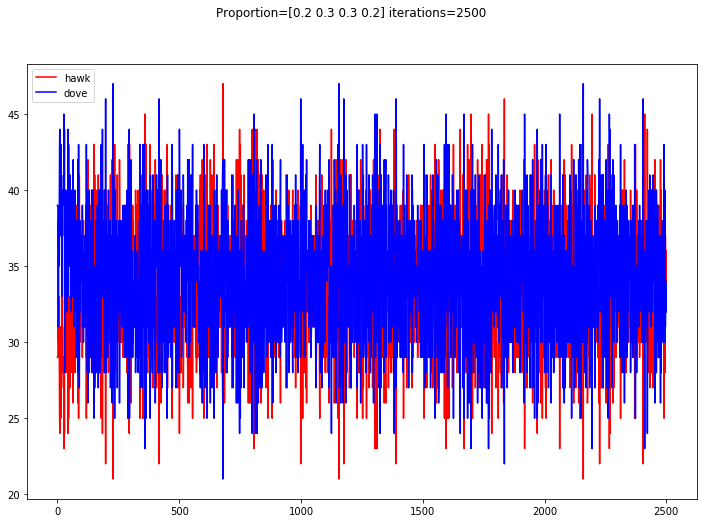

In [47]:
#show actions by round. Note that this is only showing the *primary* action, not the chosen partner action
#this is trying to get a sense of each agents choice, no double counting. 

xs = range(iterations)   

plt.figure(figsize=(12,8))
plt.plot(xs,rd['hawk'],c='r',label='hawk')
plt.plot(xs,rd['dove'],c='b',label='dove')
plt.suptitle("Proportion="+str(proportion)+" iterations="+str(iterations))
plt.legend()
plt.show()

In [ ]:
# I've eliminated some of the plotting because it was designed for the case with just two

# Now for the Replicator Dynamics

In replicator dynamics we study which strategies are evolutionary stable. To do that, we need to stipulate, at initiation, which poportion of the reds and blues are hawks and which are doves. For simplicity, we start with same proportion of hawks for the two types.

## All populations vary

Here we have the case in which all populations vary. Next we will study the case in which the red and blue populations are fixed, and what varies is what strategies they play.

In [12]:
proportion_hawk = 0.5 # proportion of hawkes at initiation for both types
# I will be still using the proportion of red and blue defined at the beginning as parameters

In [13]:
# We use lists to keep track of populations cause they change at each iteration
prop_red_hawk = [(pop_red*proportion_hawk)/num_agents]
prop_red_dove = [(pop_red*(1-proportion_hawk))/num_agents]
prop_blue_hawk = [(pop_blue*proportion_hawk)/num_agents]
prop_blue_dove = [(pop_blue*(1-proportion_hawk))/num_agents]

# Time step
dt = 0.05

# fitness for each population. Again we use lists because these change at each time step
# fitness is basically the expected value for a given (population,strategy) pair, given the proportions of each
# population type as well as the payoffs obtained in the game
# i.e. fitness_red_hawk = (agree_payoff * red_proportion) + (hawk-hawk_payoff * prop_blue_hawks) + (hawk-dove_payoff * prop_blue_dove)
F_red_hawk = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_red_dove = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['dove']['hawk'])+(prop_blue_dove[0]*disagree_dict['dove']['dove']))*dt]
F_blue_hawk = [((agree_payoff * (prop_blue_hawk[0] + prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_red_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_blue_dove = [((agree_payoff * (prop_blue_hawk[0]+prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['dove']['hawk'])+(prop_red_dove[0]*disagree_dict['dove']['dove']))*dt]

# Average fitness
F_average = [((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0])+(F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*dt]

In [14]:
print(prop_blue_hawk)
print(F_red_dove)
print(prop_red_hawk[0]+prop_red_dove[0]+prop_blue_hawk[0]+prop_blue_dove[0])

[0.375]
[0.003125]
1.0


In [15]:
# Simulations
# So at each stage we keep track of the population proportions of each type and stragegy, as well as the fitness for each type-strategy
for t in range(200):
    # fitnesses for populations at t
    f_red_hawk = (agree_payoff * (prop_red_hawk[t] + prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[t]*disagree_dict['hawk']['dove'])
    f_red_dove = (agree_payoff * (prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['dove']['hawk'])+(prop_blue_dove[t]*disagree_dict['dove']['dove'])
    f_blue_hawk = (agree_payoff * (prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_red_dove[t]*disagree_dict['hawk']['dove'])
    f_blue_dove = (agree_payoff * (prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['dove']['hawk'])+(prop_red_dove[t]*disagree_dict['dove']['dove'])

    # Average fitness at t
    f_average = (f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t])+(f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t])
    
    # update the fitness lists
    F_red_hawk.append(f_red_hawk*dt)
    F_red_dove.append(f_red_dove*dt)
    F_blue_hawk.append(f_blue_hawk*dt)
    F_blue_dove.append(f_blue_dove*dt)
    F_average.append(f_average*dt)
    
    # update equations for populations
    # the idea is that at each time step (dt), the population will change in accordance to the fitness (that is why we multiply by dt)
    # in our familiar RL notation: new_population = old_population + step_size*(old_population*(pop_fitness - average_fitness))
    # here step_size is dt
    # The idea here is that each population is updated according to how successful they
    # were in the previous iteration: d_pop/dt = pop*(f_pop - f_average)
    # Our update is: new_prop = old_prop + old_prop*(pop_fitness - average_fitness)
    prop_red_hawk.append(prop_red_hawk[t]+dt*(prop_red_hawk[t]*(f_red_hawk-f_average)))
    prop_red_dove.append(prop_red_dove[t]+dt*(prop_red_dove[t]*(f_red_dove-f_average)))
    prop_blue_hawk.append(prop_blue_hawk[t]+dt*(prop_blue_hawk[t]*(f_blue_hawk-f_average)))
    prop_blue_dove.append(prop_blue_dove[t]+dt*(prop_blue_dove[t]*(f_blue_dove-f_average)))
    
    

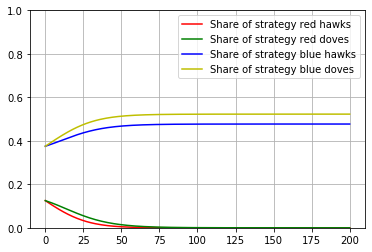

In [16]:
# Plotting
# If you try a minority of red (proportion = 0.25) and start with equal hawk-dove proportions at each population
# you will notice that the reds disappear in time, and blues have a majority of doves and a close minority of hawks
# If I knew how to plot nicely, its possible to also observe the fitness evolution
plt.plot(prop_red_hawk, 'r', label ='Share of strategy red hawks')
plt.plot(prop_red_dove, 'g', label ='Share of strategy red doves')
plt.plot(prop_blue_hawk, 'b', label ='Share of strategy blue hawks')
plt.plot(prop_blue_dove, 'y', label ='Share of strategy blue doves')
plt.grid()
plt.ylim(0, 1)
plt.legend(loc='best')

# Only strategy populations vary, but not type

In the case before, we allowed the populations of each type to change. Also, fitness was compared relative to the overall population. Here we have the proportions of red and blue fixed; but within each type the proportion of hawks and doves changes. The fitness is comparable only intra group.

In [17]:
# We use lists to keep track of populations cause they change at each iteration
prop_red_hawk = [(pop_red*proportion_hawk)/num_agents]
prop_red_dove = [(pop_red*(1-proportion_hawk))/num_agents]
prop_red = pop_red/num_agents
prop_blue_hawk = [(pop_blue*proportion_hawk)/num_agents]
prop_blue_dove = [(pop_blue*(1-proportion_hawk))/num_agents]
prop_blue = pop_blue/num_agents

# Time step
dt = 0.05

# fitness for each population.
# Notice that here we don't use the average population fitness but the in-group fitness
F_red_hawk = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_red_dove = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['dove']['hawk'])+(prop_blue_dove[0]*disagree_dict['dove']['dove']))*dt]
F_blue_hawk = [((agree_payoff * (prop_blue_hawk[0] + prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_red_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_blue_dove = [((agree_payoff * (prop_blue_hawk[0]+prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['dove']['hawk'])+(prop_red_dove[0]*disagree_dict['dove']['dove']))*dt]

# Average fitness
F_average = [((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0])+(F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*dt]

# The catch now is that the population dynamics is defined for each group independently
# So we need to compute the average fitness for each group
F_average_red = [(((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0]))*(1/prop_red))*dt]
F_average_blue = [(((F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*(1/prop_blue))*dt]



In [18]:
print(prop_blue_hawk)
print(F_red_dove)
print(prop_red_hawk[0]+prop_red_dove[0]+prop_blue_hawk[0]+prop_blue_dove[0])

[0.375]
[0.003125]
1.0


In [19]:
# Simulations

for t in range(750):
    # fitnesses for populations at t
    f_red_hawk = (agree_payoff*(prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[t]*disagree_dict['hawk']['dove'])
    f_red_dove = (agree_payoff*(prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['dove']['hawk'])+(prop_blue_dove[t]*disagree_dict['dove']['dove'])
    f_blue_hawk = (agree_payoff*(prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_red_dove[t]*disagree_dict['hawk']['dove'])
    f_blue_dove = (agree_payoff*(prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['dove']['hawk'])+(prop_red_dove[t]*disagree_dict['dove']['dove'])

    # Average fitness at t
    f_average = (f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t])+(f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t])
    
    # Since the evolutionary dynamics is within group, we need to compare, for each group
    # which strategy is more stable
    # We have to normalize by the proportion of reds and blues
    f_average_red = ((f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t]))*(1/prop_red)
    f_average_blue = ((f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t]))*(1/prop_blue)
    
    # update the fitness lists
    F_red_hawk.append(f_red_hawk*dt)
    F_red_dove.append(f_red_dove*dt)
    F_blue_hawk.append(f_blue_hawk*dt)
    F_blue_dove.append(f_blue_dove*dt)
    F_average.append(f_average*dt)
    F_average_red.append(f_average_red*dt)
    F_average_blue.append(f_average_blue*dt)
    
    # update equations for populations
    # Our update is: new_prop = old_prop + step_size*(old_prop*(pop_fitness - average_GROUP_fitness))
    prop_red_hawk.append(prop_red_hawk[t]+dt*(prop_red_hawk[t]*(f_red_hawk-f_average_red)))
    prop_red_dove.append(prop_red_dove[t]+dt*(prop_red_dove[t]*(f_red_dove-f_average_red)))
    prop_blue_hawk.append(prop_blue_hawk[t]+dt*(prop_blue_hawk[t]*(f_blue_hawk-f_average_blue)))
    prop_blue_dove.append(prop_blue_dove[t]+dt*(prop_blue_dove[t]*(f_blue_dove-f_average_blue)))
    
    

In [20]:
# To check that the equations are note messing up the populations
print(prop_red_hawk[0]+prop_red_dove[0])
print(prop_red_hawk[750]+prop_red_dove[750])

print(prop_blue_hawk[0]+prop_blue_dove[0])
print(prop_blue_hawk[750]+prop_blue_dove[750])

0.25
0.24999999999999944
0.75
0.7500000000000001


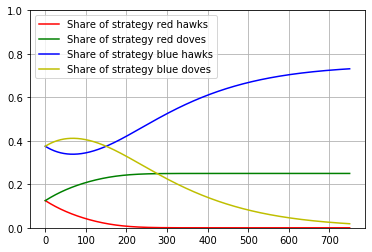

In [21]:
# Plotting is the same
# This is a curious case!
# If you start with a minority of red (proportion = 0.25) and equal proportions of hawk and doves,
# then red stabilize being doves and blues being hawks
# namely, the reds (minority) evolve to become submissive and the blues become dominant (majority)
plt.plot(prop_red_hawk, 'r', label ='Share of strategy red hawks')
plt.plot(prop_red_dove, 'g', label ='Share of strategy red doves')
plt.plot(prop_blue_hawk, 'b', label ='Share of strategy blue hawks')
plt.plot(prop_blue_dove, 'y', label ='Share of strategy blue doves')
plt.grid()
plt.ylim(0, 1)
plt.legend(loc='best')

# Only stregy populations vary, but now with epsilon mutation

This is just like the case before, but now we have an epsilon parameter of mutation.
The idea is that at each stage a fixed proportion epsilon of the whole population mutates at random.
This is very similar to the epsilon exploration in RL.
So having fixed populations of types (red, blue) plus some epsilon mutation is the closest I can think of to compare with using epsilon greedy in the bandit case before.

In [22]:
# The fitness equations are the same as the last case
# We use lists to keep track of populations cause they change at each iteration
prop_red_hawk = [(pop_red*proportion_hawk)/num_agents]
prop_red_dove = [(pop_red*(1-proportion_hawk))/num_agents]
prop_red = pop_red/num_agents
prop_blue_hawk = [(pop_blue*proportion_hawk)/num_agents]
prop_blue_dove = [(pop_blue*(1-proportion_hawk))/num_agents]
prop_blue = pop_blue/num_agents

# Time step
dt = 0.05

# fitness for each population.
F_red_hawk = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_red_dove = [((agree_payoff * (prop_red_hawk[0] + prop_red_dove[0]))+(prop_blue_hawk[0]*disagree_dict['dove']['hawk'])+(prop_blue_dove[0]*disagree_dict['dove']['dove']))*dt]
F_blue_hawk = [((agree_payoff * (prop_blue_hawk[0] + prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['hawk']['hawk'])+(prop_red_dove[0]*disagree_dict['hawk']['dove']))*dt]
F_blue_dove = [((agree_payoff * (prop_blue_hawk[0]+prop_blue_dove[0]))+(prop_red_hawk[0]*disagree_dict['dove']['hawk'])+(prop_red_dove[0]*disagree_dict['dove']['dove']))*dt]

# Average fitness
F_average = [((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0])+(F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*dt]

# The catch now is that the population dynamics is defined for each group independently
# So we need to compute the average fitness for each group
F_average_red = [(((F_red_hawk[0]*prop_red_hawk[0])+(F_red_dove[0]*prop_red_dove[0]))*(1/prop_red))*dt]
F_average_blue = [(((F_blue_hawk[0]*prop_blue_hawk[0])+(F_blue_dove[0]*prop_blue_dove[0]))*(1/prop_blue))*dt]

In [23]:
print(prop_red_dove)
print(F_red_dove)
print(prop_red_hawk[0]+prop_red_dove[0]+prop_blue_hawk[0]+prop_blue_dove[0])
print(epsilon/2)

[0.125]
[0.003125]
1.0
0.05


In [24]:
# Simulations

for t in range(750):
    # fitnesses for populations at t
    f_red_hawk = (agree_payoff*(prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_blue_dove[t]*disagree_dict['hawk']['dove'])
    f_red_dove = (agree_payoff*(prop_red_hawk[t]+prop_red_dove[t]))+(prop_blue_hawk[t]*disagree_dict['dove']['hawk'])+(prop_blue_dove[t]*disagree_dict['dove']['dove'])
    f_blue_hawk = (agree_payoff*(prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['hawk']['hawk'])+(prop_red_dove[t]*disagree_dict['hawk']['dove'])
    f_blue_dove = (agree_payoff*(prop_blue_hawk[t]+prop_blue_dove[t]))+(prop_red_hawk[t]*disagree_dict['dove']['hawk'])+(prop_red_dove[t]*disagree_dict['dove']['dove'])

    # Average fitness at t
    f_average = (f_red_hawk*prop_red_hawk[t])+(f_red_dove*prop_red_dove[t])+(f_blue_hawk*prop_blue_hawk[t])+(f_blue_dove*prop_blue_dove[t])
    
    # Since the evolutionary dynamics is within group, we need to compare, for each group
    # which strategy is more stable
    # The replicator-mutator dynamics is a bit more complicated, so there will be some extra normalization
    # steps. That is why the normalization is a bit weird here. I try to explain it below.
    prop_red_hawk_normalized = prop_red_hawk[t]*(1/prop_red)
    prop_red_dove_normalized = prop_red_dove[t]*(1/prop_red)
    f_average_red = ((f_red_hawk*prop_red_hawk_normalized)+(f_red_dove*prop_red_dove_normalized))       
    
    prop_blue_hawk_normalized = prop_blue_hawk[t]*(1/prop_blue)
    prop_blue_dove_normalized = prop_blue_dove[t]*(1/prop_blue)
    f_average_blue = ((f_blue_hawk*prop_blue_hawk_normalized)+(f_blue_dove*prop_blue_dove_normalized))
    
    # update the fitness lists
    F_red_hawk.append(f_red_hawk*dt)
    F_red_dove.append(f_red_dove*dt)
    F_blue_hawk.append(f_blue_hawk*dt)
    F_blue_dove.append(f_blue_dove*dt)
    F_average.append(f_average*dt)
    F_average_red.append(f_average_red*dt)
    F_average_blue.append(f_average_blue*dt)
    
    # update equations for populations
    # See explanation below   
    total_red_hawk = (1-epsilon)*prop_red_hawk_normalized*f_red_hawk + (epsilon/2)*f_average_red
    new_red_hawk_prop = prop_red_hawk_normalized + dt*(total_red_hawk - prop_red_hawk_normalized*f_average_red)
    new_red_hawk_prop_renormalized = new_red_hawk_prop*prop_red
    prop_red_hawk.append(new_red_hawk_prop_renormalized)

    total_red_dove = (1-epsilon)*prop_red_dove_normalized*f_red_dove + (epsilon/2)*f_average_red
    new_red_dove_prop = prop_red_dove_normalized + dt*(total_red_dove - prop_red_dove_normalized*f_average_red)
    new_red_dove_prop_renormalized = new_red_dove_prop*prop_red
    prop_red_dove.append(new_red_dove_prop_renormalized)
    
    total_blue_hawk = (1-epsilon)*prop_blue_hawk_normalized*f_blue_hawk + (epsilon/2)*f_average_blue
    new_blue_hawk_prop = prop_blue_hawk_normalized + dt*(total_blue_hawk - prop_blue_hawk_normalized*f_average_blue)
    new_blue_hawk_prop_renormalized = new_blue_hawk_prop*prop_blue
    prop_blue_hawk.append(new_blue_hawk_prop_renormalized)

    total_blue_dove = (1-epsilon)*prop_blue_dove_normalized*f_blue_dove + (epsilon/2)*f_average_blue
    new_blue_dove_prop = prop_blue_dove_normalized + dt*(total_blue_dove - prop_blue_dove_normalized*f_average_blue)
    new_blue_dove_prop_renormalized = new_blue_dove_prop*prop_blue
    prop_blue_dove.append(new_blue_dove_prop_renormalized)
    
    # The following is trash from previous attempts that I don't want to erase just in case
    #total_red_dove = (1-epsilon)*prop_red_dove[t]*f_red_dove + (epsilon/2)*f_average_red
    #prop_red_dove.append(prop_red_dove[t] + dt*(total_red_dove - prop_red_dove[t]*f_average_red))
    #total_blue_hawk = (1-epsilon)*prop_blue_hawk[t]*f_blue_hawk + (epsilon/2)*f_average_blue
    #prop_blue_hawk.append(prop_blue_hawk[t] + dt*(total_blue_hawk - prop_blue_hawk[t]*f_average_blue))                       
    #total_blue_dove = (1-epsilon)*prop_blue_dove[t]*f_blue_dove + (epsilon/2)*f_average_blue
    #prop_blue_dove.append(prop_blue_dove[t] + dt*(total_blue_dove - prop_blue_dove[t]*f_average_blue))
    
    # HERE THE EXPLANATION
    # Ok it gets slightly complicated here
    # Our update WITHOUT MUTATION is: 
    # new_prop = old_prop + step_size*(old_prop*(pop_fitness - average_GROUP_fitness))
    # Now things are slightly more complicated, lets think about it
    # In the previous case, at each step the CHANGE was: step_size*(old_porop*(pop_fitness - average_GROUP_fitness))
    # Let us look closely at: old_prop*(pop_fitness - average_GROUP_fitness)
    # This is the same as: old_prop*pop_fitness - old_prop*average_GROUP_fitness
    # So what this is saying is that at each step size the population will change by comparing 
    # its Total fitness (old_prop*pop_fitness) with the total fitness it would have if it were average (old_prop*average_fitness)
    
    # Ok good. In the case of mutation we can compute the total fitness of the population that will reproduce or mutate
    # into our target population:
    # (1-epsilon)*old_prop will reproduce into agents of the same type and strategy
    # So we have: (1-epsilon)*old_prop*pop_fitness as part of the total fitness
    
    # (epsilon/#number of types-strategies)*(prop_type1*fitness_type1 + prop_type2*fitness_type2 + ...) gives us the rest of
    # the total fitness of the agents that will mutate into our target type-strategy
    # Now: average_fitness = prop_type1*fitness_type1 + prop_type2*fitness_type2 + ...
    # So we actually have: (epsilon/#number of types-strategies)*average_fitness
    # Since we are making fitness comparison intra types, we consider only 2 number of types-pairs (hawk and dove)
    # This is to say that mutations occur only within type: blue mutate into blue, red into red
    
    # Ok so the total fitness for our target type-strategy is:
    # (1-epsilon)*old_prop*pop_fitness + (epsilon/2)*average_fitness
    # lets call that total_group_fitness.
    # and, as before, to that we need to substract: old_prop*average_fitness
    # So the change at each step will be:
    # step_size(total_group_fitness - old_prop*average_fitness)
    # And the update will be:
    # new_prop = old_prop + step_size*(total_group_fitness - old_prop*average_fitness)
    
    # Now for the part that took me several hours to figure out
    # the in-group population dynamics equations with mutation only secure that the red or blue population
    # remains fixed in each iteration if the prop_red_hawk + prop_red_dove = 1, and the same for the blues
    # so what we will do is compute the ecuations normalizing by 1/prop_red and 1/prop_blue,
    # and then normalize back by multiplying for prop_red and prop_blue


In [25]:
print(prop_red_hawk[0]+prop_red_dove[0])
print(prop_red_hawk[750]+prop_red_dove[750])

print(prop_blue_hawk[0]+prop_blue_dove[0])
print(prop_blue_hawk[750]+prop_blue_dove[750])

print(prop_red_hawk[0]+prop_red_dove[0]+prop_blue_hawk[0]+prop_blue_dove[0])
print(prop_red_hawk[750]+prop_red_dove[750]+prop_blue_hawk[750]+prop_blue_dove[750])

0.25
0.24999999999999908
0.75
0.7499999999999989
1.0
0.999999999999998


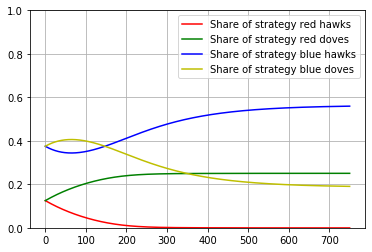

In [26]:
# Plotting is the same
# Again we get that the majority becomes dominant and the minority becomes submissive (proportion = 0.25, hawkpop = 0.5)
# Its basically the same graph as before... and this took me several hours. Oh, well...
plt.plot(prop_red_hawk, 'r', label ='Share of strategy red hawks')
plt.plot(prop_red_dove, 'g', label ='Share of strategy red doves')
plt.plot(prop_blue_hawk, 'b', label ='Share of strategy blue hawks')
plt.plot(prop_blue_dove, 'y', label ='Share of strategy blue doves')
plt.grid()
plt.ylim(0, 1)
plt.legend(loc='best')